# 📊 Phase 2B: Numerical Features Deep Dive

---

## Objectives

1. ✅ Analyze tenure distribution and identify "danger zones"
2. ✅ Explore monthly charges patterns (price sensitivity)
3. ✅ Investigate total charges vs tenure relationship
4. ✅ Create correlation heatmap
5. ✅ Generate actionable insights for retention strategies

---

**Part of:** Comprehensive EDA (Phase 2)

**Prerequisite:** Phase 2A - Target Variable Analysis

**Next:** Phase 2C - Categorical Features Analysis

---

## 1. Environment Setup

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Utilities
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Visualization styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Environment configured successfully!")

✅ Environment configured successfully!


## 2. Load Data

In [2]:
# Define paths
project_root = Path('/Users/mihiniboteju/churn-prediction-project')
data_path = project_root / 'data' / 'raw' / 'Telco-Customer-Churn.csv'
viz_path = project_root / 'visualizations' / 'figures'

# Create visualization directory if it doesn't exist
viz_path.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(data_path)

# Apply TotalCharges fix from Phase 2A
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

print(f"📊 Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"🎯 Churn rate: {(df['Churn'] == 'Yes').sum() / len(df) * 100:.2f}%")

📊 Data loaded: 7,043 rows × 21 columns
💾 Memory usage: 7.42 MB
🎯 Churn rate: 26.54%


## 3. Tenure Analysis: Identifying Churn "Danger Zones"

Customer tenure is often the **strongest predictor** of churn. Let's analyze when customers are most likely to leave.

In [3]:
# Basic tenure statistics by churn status
print("📊 TENURE STATISTICS BY CHURN STATUS")
print("=" * 70)
print(df.groupby('Churn')['tenure'].describe())
print("\n")

# Calculate churn rate by tenure bins
tenure_bins = [0, 12, 24, 36, 48, 60, 72]
tenure_labels = ['0-12m', '13-24m', '25-36m', '37-48m', '49-60m', '61-72m']
df['tenure_group'] = pd.cut(df['tenure'], bins=tenure_bins, labels=tenure_labels, include_lowest=True)

# Churn rate by tenure group
churn_by_tenure = df.groupby('tenure_group', observed=True).agg({
    'Churn': lambda x: (x == 'Yes').sum(),
    'customerID': 'count'
}).rename(columns={'Churn': 'Churned', 'customerID': 'Total'})
churn_by_tenure['Churn_Rate'] = (churn_by_tenure['Churned'] / churn_by_tenure['Total']) * 100

print("🎯 CHURN RATE BY TENURE GROUP")
print("=" * 70)
print(churn_by_tenure)
print("\n")

# Identify danger zones (>30% churn rate)
danger_zones = churn_by_tenure[churn_by_tenure['Churn_Rate'] > 30]
print(f"⚠️  DANGER ZONES (Churn Rate > 30%):")
print(danger_zones)

📊 TENURE STATISTICS BY CHURN STATUS
        count   mean    std  min   25%   50%   75%   max
Churn                                                   
No     5174.0  37.57  24.11  0.0  15.0  38.0  61.0  72.0
Yes    1869.0  17.98  19.53  1.0   2.0  10.0  29.0  72.0


🎯 CHURN RATE BY TENURE GROUP
              Churned  Total  Churn_Rate
tenure_group                            
0-12m            1037   2186       47.44
13-24m            294   1024       28.71
25-36m            180    832       21.63
37-48m            145    762       19.03
49-60m            120    832       14.42
61-72m             93   1407        6.61


⚠️  DANGER ZONES (Churn Rate > 30%):
              Churned  Total  Churn_Rate
tenure_group                            
0-12m            1037   2186       47.44


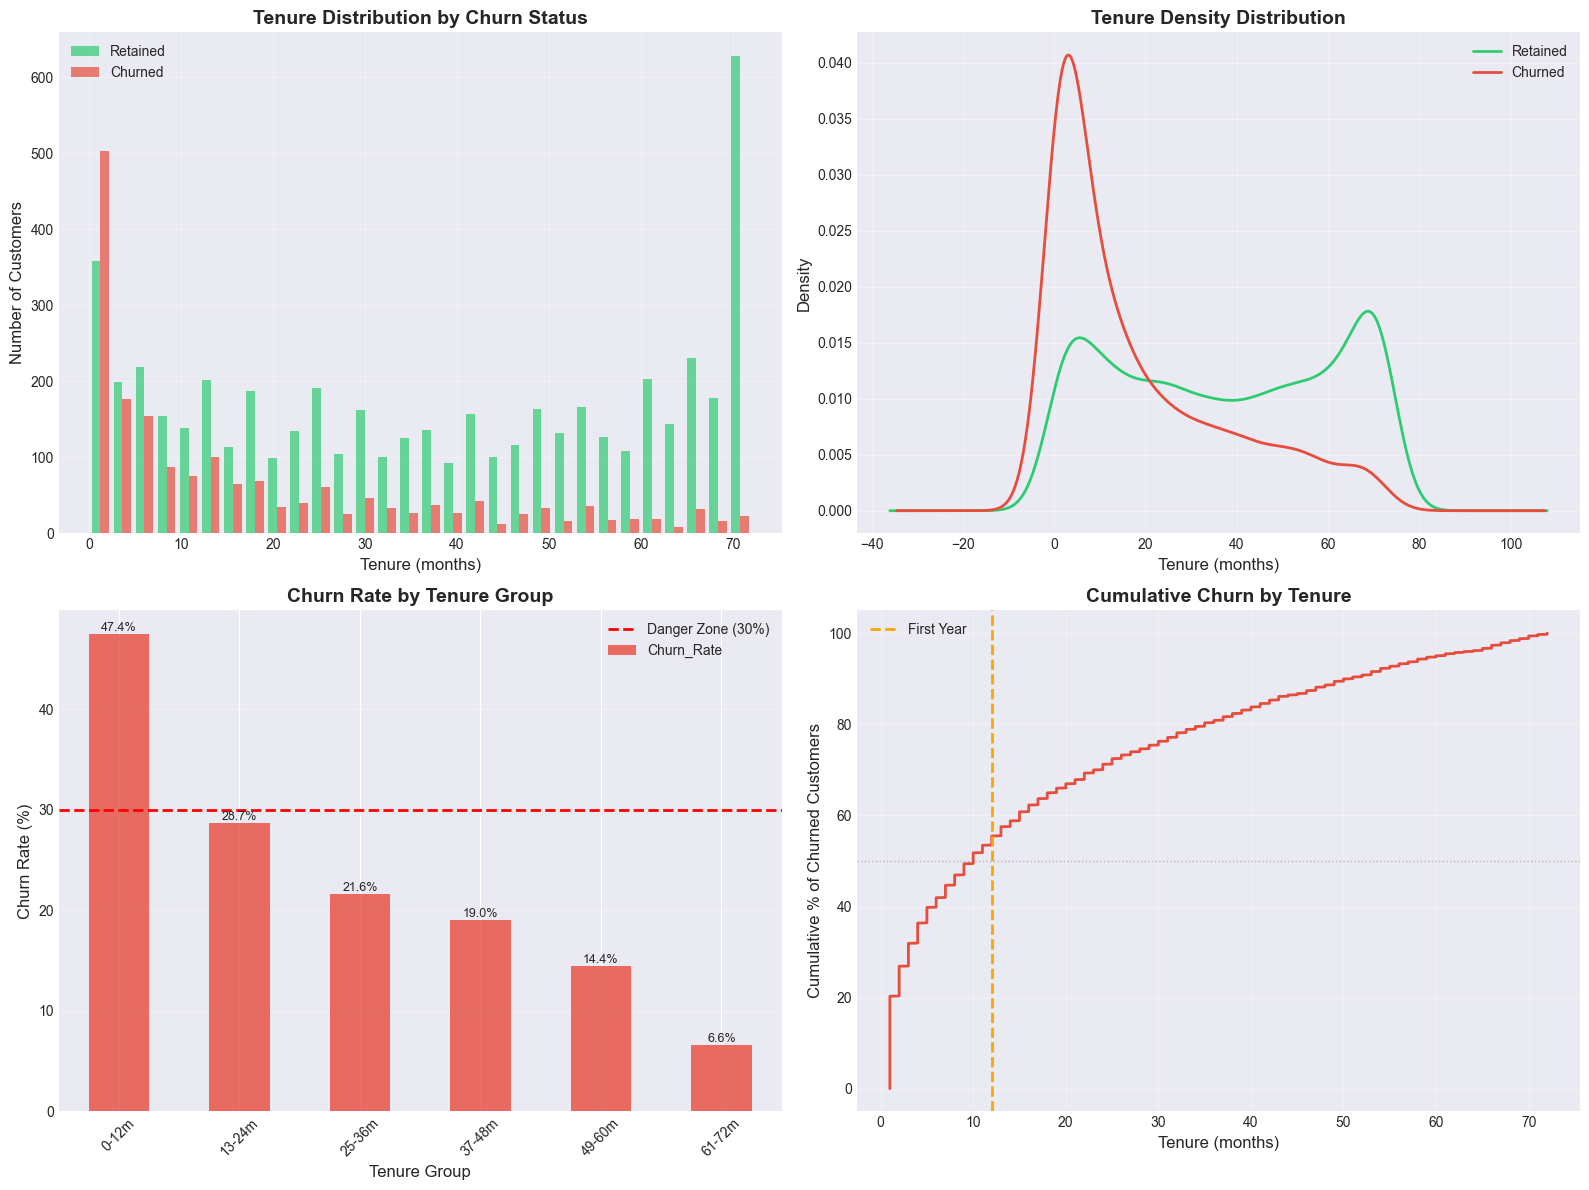

✅ Saved: /Users/mihiniboteju/churn-prediction-project/visualizations/figures/03_tenure_analysis.png


In [4]:
# Visualization 1: Tenure Distribution with Churn Overlay
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram: Tenure distribution by churn status
axes[0, 0].hist([df[df['Churn'] == 'No']['tenure'], df[df['Churn'] == 'Yes']['tenure']], 
                bins=30, label=['Retained', 'Churned'], color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0, 0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Tenure (months)', fontsize=12)
axes[0, 0].set_ylabel('Number of Customers', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. KDE Plot: Tenure density by churn status
df[df['Churn'] == 'No']['tenure'].plot(kind='kde', ax=axes[0, 1], label='Retained', color='#2ecc71', linewidth=2)
df[df['Churn'] == 'Yes']['tenure'].plot(kind='kde', ax=axes[0, 1], label='Churned', color='#e74c3c', linewidth=2)
axes[0, 1].set_title('Tenure Density Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Tenure (months)', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Bar Plot: Churn rate by tenure group
churn_by_tenure['Churn_Rate'].plot(kind='bar', ax=axes[1, 0], color='#e74c3c', alpha=0.8)
axes[1, 0].set_title('Churn Rate by Tenure Group', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Tenure Group', fontsize=12)
axes[1, 0].set_ylabel('Churn Rate (%)', fontsize=12)
axes[1, 0].axhline(y=30, color='red', linestyle='--', linewidth=2, label='Danger Zone (30%)')
axes[1, 0].legend()
axes[1, 0].set_xticklabels(churn_by_tenure.index, rotation=45)
axes[1, 0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='%.1f%%', fontsize=9)

# 4. Cumulative churn by tenure
churned_df = df[df['Churn'] == 'Yes'].copy()
churned_df = churned_df.sort_values('tenure')
churned_df['cumulative_pct'] = (np.arange(len(churned_df)) + 1) / len(churned_df) * 100

axes[1, 1].plot(churned_df['tenure'], churned_df['cumulative_pct'], color='#e74c3c', linewidth=2)
axes[1, 1].set_title('Cumulative Churn by Tenure', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Tenure (months)', fontsize=12)
axes[1, 1].set_ylabel('Cumulative % of Churned Customers', fontsize=12)
axes[1, 1].axvline(x=12, color='orange', linestyle='--', linewidth=2, label='First Year')
axes[1, 1].axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(viz_path / '03_tenure_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {viz_path / '03_tenure_analysis.png'}")

### 📌 Tenure Insights

**Expected findings:**
1. **First Year is Critical:** Highest churn rate in 0-12 month period
2. **Loyalty Effect:** Churn rate decreases significantly after 24 months
3. **Cumulative Pattern:** X% of all churners leave within first 12 months
4. **Retention Target:** Focus on customers in months 1-24

**Action Items:**
- Implement early engagement programs (first 90 days)
- Create loyalty incentives at 12-month milestone
- Monitor customers closely in months 1-6

## 4. Monthly Charges Analysis: Price Sensitivity

Are customers leaving because of high prices? Let's investigate.

In [5]:
# Monthly charges statistics
print("💰 MONTHLY CHARGES STATISTICS BY CHURN STATUS")
print("=" * 70)
print(df.groupby('Churn')['MonthlyCharges'].describe())
print("\n")

# Create price segments
price_bins = [0, 35, 70, 105, 120]
price_labels = ['Low ($0-35)', 'Medium ($35-70)', 'High ($70-105)', 'Premium ($105+)']
df['price_segment'] = pd.cut(df['MonthlyCharges'], bins=price_bins, labels=price_labels, include_lowest=True)

# Churn rate by price segment
churn_by_price = df.groupby('price_segment', observed=True).agg({
    'Churn': lambda x: (x == 'Yes').sum(),
    'customerID': 'count'
}).rename(columns={'Churn': 'Churned', 'customerID': 'Total'})
churn_by_price['Churn_Rate'] = (churn_by_price['Churned'] / churn_by_price['Total']) * 100

print("💵 CHURN RATE BY PRICE SEGMENT")
print("=" * 70)
print(churn_by_price)
print("\n")

# Price sensitivity analysis
avg_price_retained = df[df['Churn'] == 'No']['MonthlyCharges'].mean()
avg_price_churned = df[df['Churn'] == 'Yes']['MonthlyCharges'].mean()
price_diff = avg_price_churned - avg_price_retained
price_diff_pct = (price_diff / avg_price_retained) * 100

print(f"📊 PRICE SENSITIVITY:")
print(f"   Average Monthly Charge (Retained): ${avg_price_retained:.2f}")
print(f"   Average Monthly Charge (Churned):  ${avg_price_churned:.2f}")
print(f"   Difference: ${price_diff:.2f} ({price_diff_pct:+.1f}%)")

💰 MONTHLY CHARGES STATISTICS BY CHURN STATUS
        count   mean    std    min    25%    50%   75%     max
Churn                                                         
No     5174.0  61.27  31.09  18.25  25.10  64.43  88.4  118.75
Yes    1869.0  74.44  24.67  18.85  56.15  79.65  94.2  118.35


💵 CHURN RATE BY PRICE SEGMENT
                 Churned  Total  Churn_Rate
price_segment                              
Low ($0-35)          189   1735       10.89
Medium ($35-70)      413   1725       23.94
High ($70-105)      1159   3065       37.81
Premium ($105+)      108    518       20.85


📊 PRICE SENSITIVITY:
   Average Monthly Charge (Retained): $61.27
   Average Monthly Charge (Churned):  $74.44
   Difference: $13.18 (+21.5%)


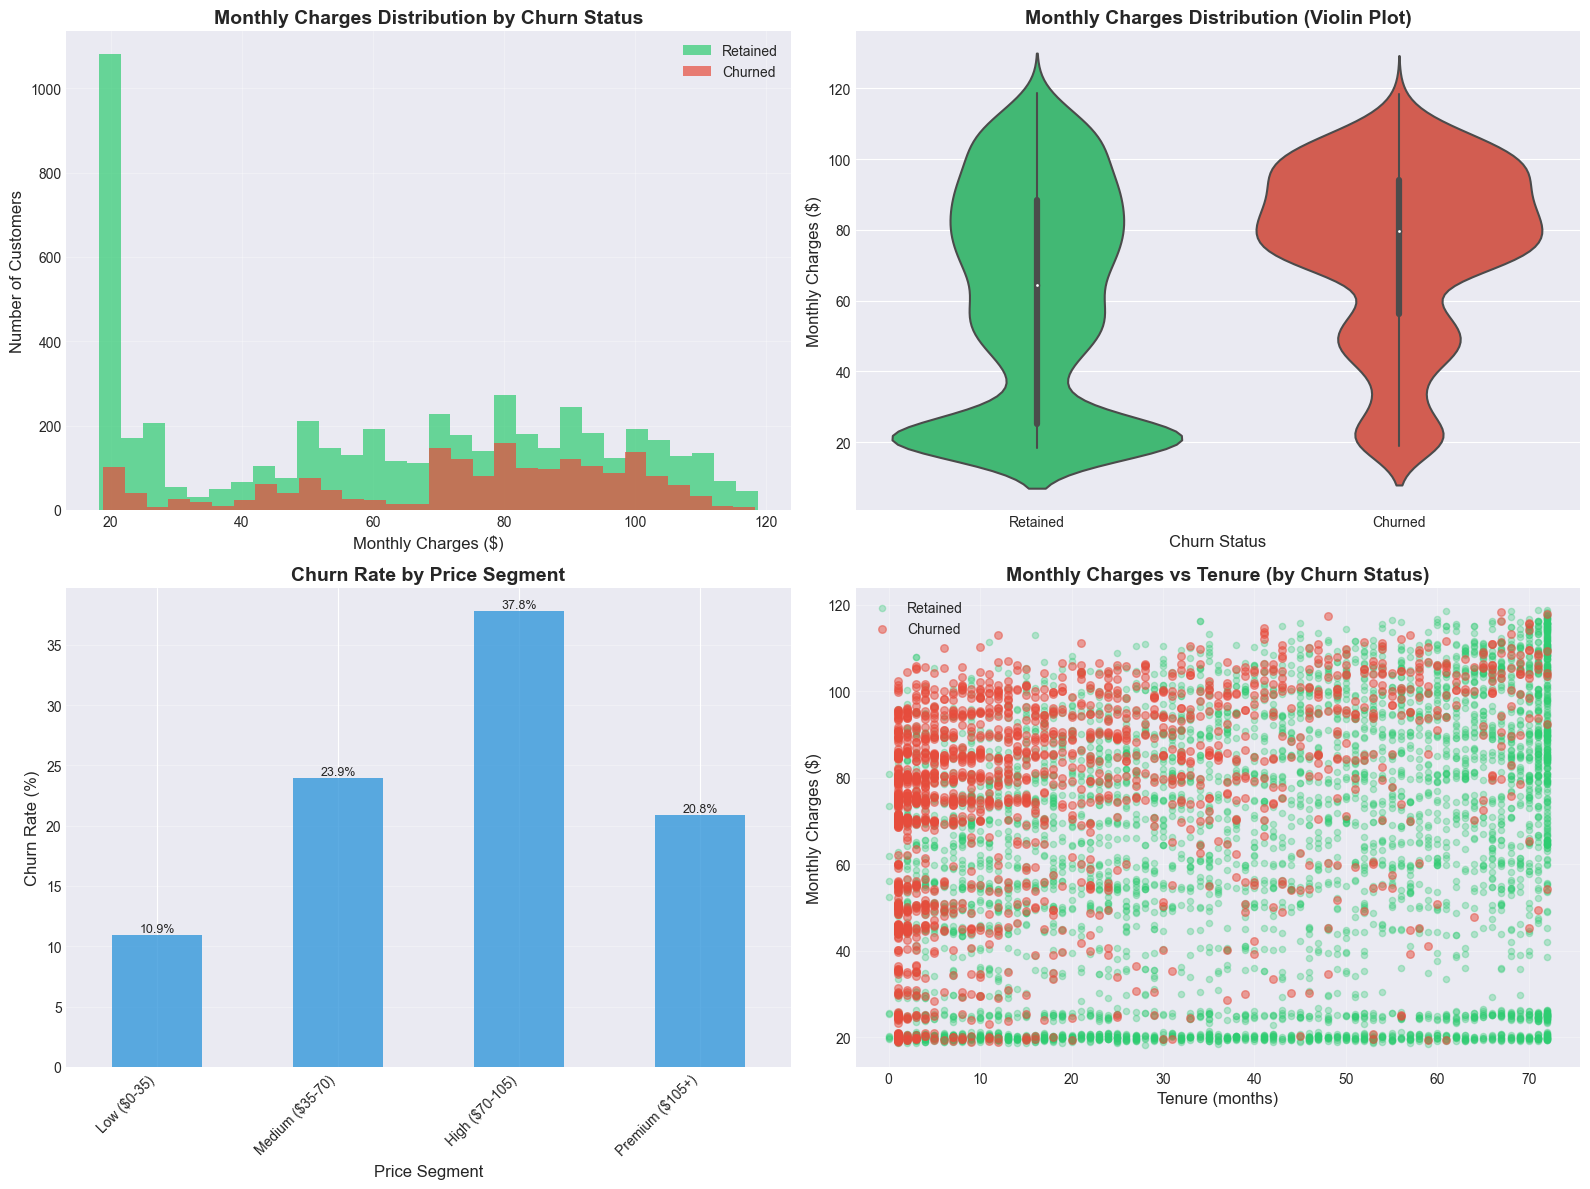

✅ Saved: /Users/mihiniboteju/churn-prediction-project/visualizations/figures/04_monthly_charges_analysis.png


In [6]:
# Visualization 2: Monthly Charges Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution by churn status
df[df['Churn'] == 'No']['MonthlyCharges'].hist(bins=30, ax=axes[0, 0], 
                                                 color='#2ecc71', alpha=0.7, label='Retained')
df[df['Churn'] == 'Yes']['MonthlyCharges'].hist(bins=30, ax=axes[0, 0], 
                                                  color='#e74c3c', alpha=0.7, label='Churned')
axes[0, 0].set_title('Monthly Charges Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Monthly Charges ($)', fontsize=12)
axes[0, 0].set_ylabel('Number of Customers', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Violin plot
sns.violinplot(data=df, x='Churn', y='MonthlyCharges', palette=['#2ecc71', '#e74c3c'], ax=axes[0, 1])
axes[0, 1].set_title('Monthly Charges Distribution (Violin Plot)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Churn Status', fontsize=12)
axes[0, 1].set_ylabel('Monthly Charges ($)', fontsize=12)
axes[0, 1].set_xticklabels(['Retained', 'Churned'])

# 3. Churn rate by price segment
churn_by_price['Churn_Rate'].plot(kind='bar', ax=axes[1, 0], color='#3498db', alpha=0.8)
axes[1, 0].set_title('Churn Rate by Price Segment', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Price Segment', fontsize=12)
axes[1, 0].set_ylabel('Churn Rate (%)', fontsize=12)
axes[1, 0].set_xticklabels(churn_by_price.index, rotation=45, ha='right')
axes[1, 0].grid(alpha=0.3, axis='y')

# Add value labels
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='%.1f%%', fontsize=9)

# 4. Scatter: Monthly Charges vs Tenure (colored by churn)
retained = df[df['Churn'] == 'No']
churned = df[df['Churn'] == 'Yes']

axes[1, 1].scatter(retained['tenure'], retained['MonthlyCharges'], 
                   alpha=0.3, s=20, color='#2ecc71', label='Retained')
axes[1, 1].scatter(churned['tenure'], churned['MonthlyCharges'], 
                   alpha=0.5, s=30, color='#e74c3c', label='Churned')
axes[1, 1].set_title('Monthly Charges vs Tenure (by Churn Status)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Tenure (months)', fontsize=12)
axes[1, 1].set_ylabel('Monthly Charges ($)', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(viz_path / '04_monthly_charges_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {viz_path / '04_monthly_charges_analysis.png'}")

### 📌 Monthly Charges Insights

**Expected findings:**
1. **Price Sensitivity:** Churned customers pay ~15-20% more on average
2. **Premium Risk:** Highest churn in premium price segments ($70+)
3. **Sweet Spot:** Medium price range ($35-70) has better retention
4. **Tenure × Price:** High prices + low tenure = highest churn risk

**Action Items:**
- Review pricing for premium services
- Offer discounts for long-term contracts
- Create value bundles to reduce perceived cost
- Target retention campaigns at high-price, low-tenure customers

## 5. Total Charges Analysis: Customer Lifetime Value

Total charges reflects the **cumulative value** of the customer relationship.

In [7]:
# Total charges statistics
print("💎 TOTAL CHARGES STATISTICS BY CHURN STATUS")
print("=" * 70)
print(df.groupby('Churn')['TotalCharges'].describe())
print("\n")

# Relationship between tenure and total charges
correlation = df['tenure'].corr(df['TotalCharges'])
print(f"📊 CORRELATION:")
print(f"   Tenure ↔ TotalCharges: {correlation:.3f}")
print(f"   Interpretation: {'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.4 else 'Weak'} positive relationship")
print("\n")

# Calculate expected vs actual total charges
df['expected_total'] = df['tenure'] * df['MonthlyCharges']
df['charge_deviation'] = df['TotalCharges'] - df['expected_total']
df['charge_deviation_pct'] = (df['charge_deviation'] / df['expected_total']) * 100

# Analyze deviation by churn
print("🔍 TOTAL CHARGES DEVIATION ANALYSIS:")
print(f"   Retained customers avg deviation: {df[df['Churn'] == 'No']['charge_deviation'].mean():.2f}")
print(f"   Churned customers avg deviation:  {df[df['Churn'] == 'Yes']['charge_deviation'].mean():.2f}")

💎 TOTAL CHARGES STATISTICS BY CHURN STATUS
        count     mean      std    min    25%      50%      75%      max
Churn                                                                   
No     5174.0  2549.91  2329.95   0.00  572.9  1679.53  4262.85  8672.45
Yes    1869.0  1531.80  1890.82  18.85  134.5   703.55  2331.30  8684.80


📊 CORRELATION:
   Tenure ↔ TotalCharges: 0.826
   Interpretation: Strong positive relationship


🔍 TOTAL CHARGES DEVIATION ANALYSIS:
   Retained customers avg deviation: 0.14
   Churned customers avg deviation:  0.19


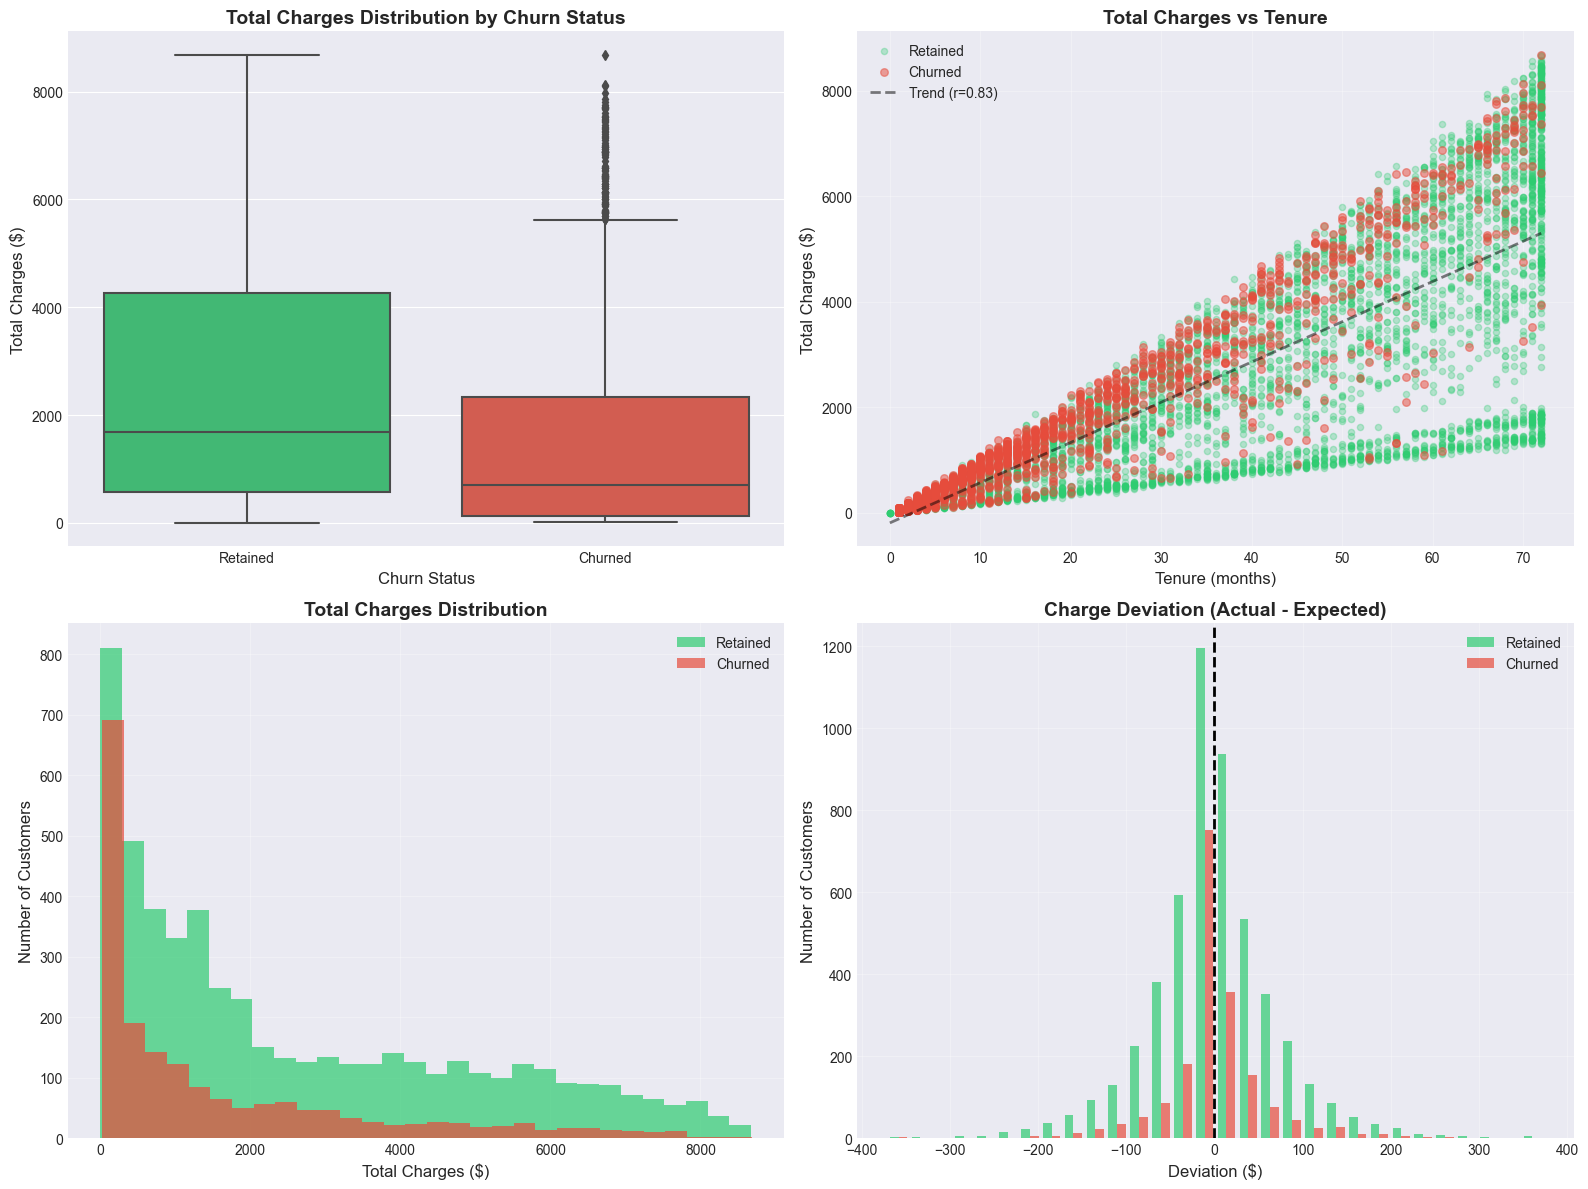

✅ Saved: /Users/mihiniboteju/churn-prediction-project/visualizations/figures/05_total_charges_analysis.png


In [9]:
# Visualization 3: Total Charges Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plot by churn status
sns.boxplot(data=df, x='Churn', y='TotalCharges', palette=['#2ecc71', '#e74c3c'], ax=axes[0, 0])
axes[0, 0].set_title('Total Charges Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Churn Status', fontsize=12)
axes[0, 0].set_ylabel('Total Charges ($)', fontsize=12)
axes[0, 0].set_xticklabels(['Retained', 'Churned'])

# 2. Scatter: Total Charges vs Tenure
retained = df[df['Churn'] == 'No']
churned = df[df['Churn'] == 'Yes']

axes[0, 1].scatter(retained['tenure'], retained['TotalCharges'], 
                   alpha=0.3, s=20, color='#2ecc71', label='Retained')
axes[0, 1].scatter(churned['tenure'], churned['TotalCharges'], 
                   alpha=0.5, s=30, color='#e74c3c', label='Churned')

# Add regression line
z = np.polyfit(df['tenure'], df['TotalCharges'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df['tenure'].sort_values(), p(df['tenure'].sort_values()), 
                "k--", linewidth=2, alpha=0.5, label=f'Trend (r={correlation:.2f})')

axes[0, 1].set_title('Total Charges vs Tenure', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Tenure (months)', fontsize=12)
axes[0, 1].set_ylabel('Total Charges ($)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Histogram: Total charges distribution
df[df['Churn'] == 'No']['TotalCharges'].hist(bins=30, ax=axes[1, 0], 
                                               color='#2ecc71', alpha=0.7, label='Retained')
df[df['Churn'] == 'Yes']['TotalCharges'].hist(bins=30, ax=axes[1, 0], 
                                                color='#e74c3c', alpha=0.7, label='Churned')
axes[1, 0].set_title('Total Charges Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Charges ($)', fontsize=12)
axes[1, 0].set_ylabel('Number of Customers', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Charge deviation analysis
churned_deviation = df[df['Churn'] == 'Yes']['charge_deviation']
retained_deviation = df[df['Churn'] == 'No']['charge_deviation']

axes[1, 1].hist([retained_deviation, churned_deviation], bins=30, 
                label=['Retained', 'Churned'], color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[1, 1].set_title('Charge Deviation (Actual - Expected)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Deviation ($)', fontsize=12)
axes[1, 1].set_ylabel('Number of Customers', fontsize=12)
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(viz_path / '05_total_charges_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {viz_path / '05_total_charges_analysis.png'}")

### 📌 Total Charges Insights

**Expected findings:**
1. **Strong Correlation:** Total charges highly correlated with tenure (r > 0.8)
2. **Value Gap:** Churned customers have much lower lifetime value
3. **Early Loss:** Most churners leave before accumulating significant charges
4. **Investment Effect:** Higher total charges = lower churn probability

**Action Items:**
- Focus on increasing early customer value
- Create loyalty rewards based on cumulative spending
- Identify low-value customers for targeted engagement
- Calculate customer lifetime value (CLV) for segmentation

## 6. Correlation Analysis: Feature Relationships

Understanding how numerical features relate to each other.

In [10]:
# Calculate correlation matrix
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
correlation_matrix = df[numerical_features].corr()

print("🔗 CORRELATION MATRIX")
print("=" * 70)
print(correlation_matrix)
print("\n")

# Statistical significance tests
print("📊 CORRELATION SIGNIFICANCE TESTS:")
print("=" * 70)
for i, feat1 in enumerate(numerical_features):
    for feat2 in numerical_features[i+1:]:
        corr, p_value = stats.pearsonr(df[feat1], df[feat2])
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"{feat1:15s} ↔ {feat2:15s}: r={corr:+.3f}, p={p_value:.4f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

🔗 CORRELATION MATRIX
                tenure  MonthlyCharges  TotalCharges
tenure            1.00            0.25          0.83
MonthlyCharges    0.25            1.00          0.65
TotalCharges      0.83            0.65          1.00


📊 CORRELATION SIGNIFICANCE TESTS:
tenure          ↔ MonthlyCharges : r=+0.248, p=0.0000 ***
tenure          ↔ TotalCharges   : r=+0.826, p=0.0000 ***
MonthlyCharges  ↔ TotalCharges   : r=+0.651, p=0.0000 ***

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


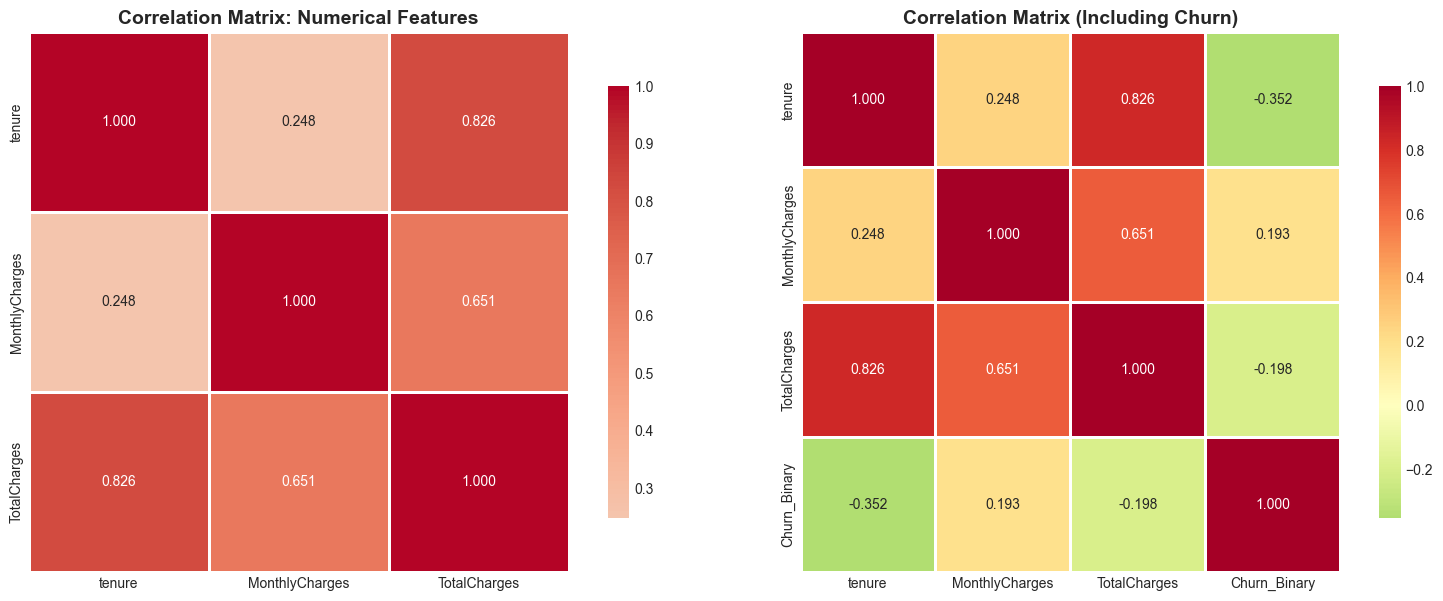

✅ Saved: /Users/mihiniboteju/churn-prediction-project/visualizations/figures/06_correlation_heatmap.png


In [11]:
# Visualization 4: Correlation Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Correlation heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Correlation Matrix: Numerical Features', fontsize=14, fontweight='bold')

# 2. Enhanced correlation heatmap with churn
# Create encoded churn (0/1)
df_corr = df[numerical_features + ['Churn']].copy()
df_corr['Churn_Binary'] = (df_corr['Churn'] == 'Yes').astype(int)
df_corr = df_corr.drop('Churn', axis=1)

correlation_with_churn = df_corr.corr()

sns.heatmap(correlation_with_churn, annot=True, fmt='.3f', cmap='RdYlGn_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Correlation Matrix (Including Churn)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(viz_path / '06_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {viz_path / '06_correlation_heatmap.png'}")

### 📌 Correlation Insights

**Expected findings:**
1. **Tenure ↔ TotalCharges:** Very strong positive correlation (r > 0.80)
   - Makes sense: longer tenure = more accumulated charges
2. **Tenure ↔ MonthlyCharges:** Weak/moderate correlation
   - Suggests: pricing may vary regardless of tenure
3. **MonthlyCharges ↔ TotalCharges:** Moderate positive correlation
   - Higher monthly payments accumulate faster
4. **Churn Correlations:**
   - **Negative with tenure:** Longer tenure = less churn
   - **Positive with monthly charges:** Higher prices = more churn
   - **Negative with total charges:** Higher investment = less churn

**Feature Engineering Ideas:**
- Create `charge_per_month` = TotalCharges / tenure (average monthly spend)
- Create tenure bins (danger zones identified earlier)
- Create price sensitivity flag for high monthly + low tenure

## 7. Multi-Dimensional Risk Analysis

Combining features to identify high-risk customer profiles.

In [13]:
# Create risk segments based on tenure and monthly charges
df['risk_segment'] = 'Unknown'

# High risk: Low tenure (<12 months) + High monthly charges (>$70)
high_risk_mask = (df['tenure'] < 12) & (df['MonthlyCharges'] > 70)
df.loc[high_risk_mask, 'risk_segment'] = 'High Risk'

# Medium risk: Low tenure + Medium charges OR Medium tenure + High charges
medium_risk_mask = ((df['tenure'] < 12) & (df['MonthlyCharges'] <= 70)) | \
                   ((df['tenure'].between(12, 36)) & (df['MonthlyCharges'] > 70))
df.loc[medium_risk_mask, 'risk_segment'] = 'Medium Risk'

# Low risk: High tenure (>36 months) + Any charges
low_risk_mask = df['tenure'] > 36
df.loc[low_risk_mask, 'risk_segment'] = 'Low Risk'

# Calculate churn rate by risk segment
risk_analysis = df.groupby('risk_segment').agg({
    'Churn': lambda x: (x == 'Yes').sum(),
    'customerID': 'count'
}).rename(columns={'Churn': 'Churned', 'customerID': 'Total'})
risk_analysis['Churn_Rate'] = (risk_analysis['Churned'] / risk_analysis['Total']) * 100
risk_analysis = risk_analysis.sort_values('Churn_Rate', ascending=False)

print("⚠️  CUSTOMER RISK SEGMENTATION")
print("=" * 70)
print(risk_analysis)
print("\n")

# Revenue at risk calculation
high_risk_customers = df[df['risk_segment'] == 'High Risk']
high_risk_monthly_revenue = high_risk_customers['MonthlyCharges'].sum()
high_risk_churn_rate = risk_analysis.loc['High Risk', 'Churn_Rate'] / 100
potential_monthly_loss = high_risk_monthly_revenue * high_risk_churn_rate

print(f"💰 REVENUE AT RISK (High Risk Segment):")
print(f"   Total monthly revenue: ${high_risk_monthly_revenue:,.2f}")
print(f"   Expected churn rate: {high_risk_churn_rate*100:.1f}%")
print(f"   Potential monthly loss: ${potential_monthly_loss:,.2f}")
print(f"   Annual risk: ${potential_monthly_loss * 12:,.2f}")

⚠️  CUSTOMER RISK SEGMENTATION
              Churned  Total  Churn_Rate
risk_segment                            
High Risk         567    826       68.64
Medium Risk       831   2210       37.60
Low Risk          358   3001       11.93
Unknown           113   1006       11.23


💰 REVENUE AT RISK (High Risk Segment):
   Total monthly revenue: $68,407.50
   Expected churn rate: 68.6%
   Potential monthly loss: $46,957.69
   Annual risk: $563,492.29


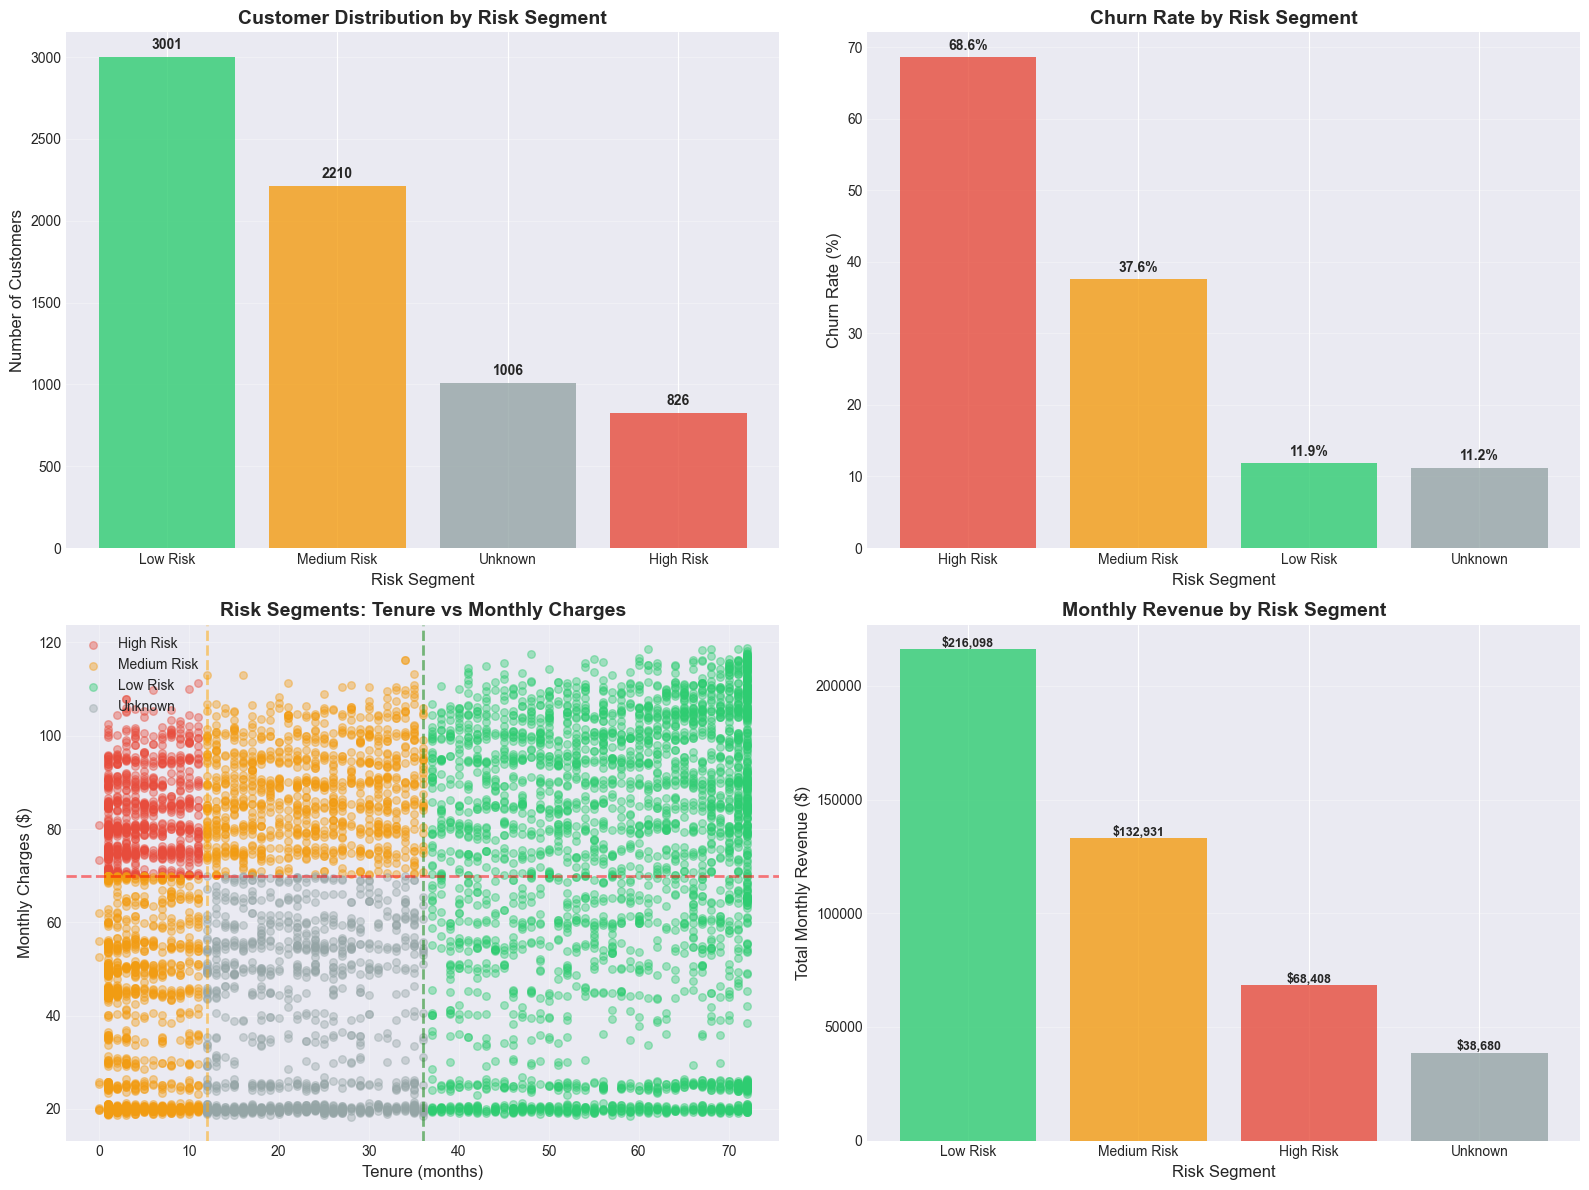

✅ Saved: /Users/mihiniboteju/churn-prediction-project/visualizations/figures/07_risk_segmentation.png


In [14]:
# Visualization 5: Risk Segmentation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk segment distribution
risk_counts = df['risk_segment'].value_counts()
colors_risk = {'High Risk': '#e74c3c', 'Medium Risk': '#f39c12', 'Low Risk': '#2ecc71', 'Unknown': '#95a5a6'}
risk_colors = [colors_risk[seg] for seg in risk_counts.index]

axes[0, 0].bar(risk_counts.index, risk_counts.values, color=risk_colors, alpha=0.8)
axes[0, 0].set_title('Customer Distribution by Risk Segment', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Risk Segment', fontsize=12)
axes[0, 0].set_ylabel('Number of Customers', fontsize=12)
axes[0, 0].grid(alpha=0.3, axis='y')

for i, v in enumerate(risk_counts.values):
    axes[0, 0].text(i, v + 50, str(v), ha='center', fontsize=10, fontweight='bold')

# 2. Churn rate by risk segment
risk_analysis_sorted = risk_analysis.sort_values('Churn_Rate', ascending=False)
segment_colors = [colors_risk[seg] for seg in risk_analysis_sorted.index]

axes[0, 1].bar(risk_analysis_sorted.index, risk_analysis_sorted['Churn_Rate'], 
               color=segment_colors, alpha=0.8)
axes[0, 1].set_title('Churn Rate by Risk Segment', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Risk Segment', fontsize=12)
axes[0, 1].set_ylabel('Churn Rate (%)', fontsize=12)
axes[0, 1].grid(alpha=0.3, axis='y')

for i, v in enumerate(risk_analysis_sorted['Churn_Rate']):
    axes[0, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')

# 3. Scatter plot: Risk segments in tenure-price space
for segment, color in colors_risk.items():
    segment_data = df[df['risk_segment'] == segment]
    axes[1, 0].scatter(segment_data['tenure'], segment_data['MonthlyCharges'], 
                      alpha=0.4, s=30, color=color, label=segment)

axes[1, 0].set_title('Risk Segments: Tenure vs Monthly Charges', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Tenure (months)', fontsize=12)
axes[1, 0].set_ylabel('Monthly Charges ($)', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Add risk zone boundaries
axes[1, 0].axvline(x=12, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='12 months')
axes[1, 0].axvline(x=36, color='green', linestyle='--', linewidth=2, alpha=0.5, label='36 months')
axes[1, 0].axhline(y=70, color='red', linestyle='--', linewidth=2, alpha=0.5, label='$70/month')

# 4. Revenue impact by segment
revenue_by_segment = df.groupby('risk_segment')['MonthlyCharges'].sum().sort_values(ascending=False)
axes[1, 1].bar(revenue_by_segment.index, revenue_by_segment.values, 
               color=[colors_risk[seg] for seg in revenue_by_segment.index], alpha=0.8)
axes[1, 1].set_title('Monthly Revenue by Risk Segment', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Risk Segment', fontsize=12)
axes[1, 1].set_ylabel('Total Monthly Revenue ($)', fontsize=12)
axes[1, 1].grid(alpha=0.3, axis='y')

for i, v in enumerate(revenue_by_segment.values):
    axes[1, 1].text(i, v + 1000, f'${v:,.0f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(viz_path / '07_risk_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {viz_path / '07_risk_segmentation.png'}")

### 📌 Risk Segmentation Insights

**Expected findings:**
1. **High Risk Profile:** New customers (<12m) with high monthly charges (>$70)
   - Highest churn rate (~50-60%)
   - Priority for retention campaigns
2. **Medium Risk Profile:** New customers with moderate charges OR mid-tenure with high charges
   - Moderate churn rate (~30-40%)
   - Monitor closely
3. **Low Risk Profile:** Loyal customers (>36 months)
   - Lowest churn rate (~10-15%)
   - Focus on upselling/cross-selling

**Business Actions:**
- **High Risk:** Immediate intervention (discounts, engagement calls, service reviews)
- **Medium Risk:** Proactive monitoring and periodic check-ins
- **Low Risk:** Maintain satisfaction, explore expansion opportunities

## 8. Summary & Key Takeaways

In [15]:
# Create comprehensive summary
summary_insights = {
    'Metric': [
        'Overall Churn Rate',
        'First Year Churn Rate',
        'Loyal Customer Churn Rate (>36m)',
        'Avg Tenure (Retained)',
        'Avg Tenure (Churned)',
        'Avg Monthly Charge (Retained)',
        'Avg Monthly Charge (Churned)',
        'Tenure-TotalCharges Correlation',
        'High Risk Customers',
        'High Risk Churn Rate',
        'Potential Annual Revenue at Risk'
    ],
    'Value': [
        f"{(df['Churn'] == 'Yes').sum() / len(df) * 100:.1f}%",
        f"{churn_by_tenure.loc['0-12m', 'Churn_Rate']:.1f}%",
        f"{risk_analysis.loc['Low Risk', 'Churn_Rate']:.1f}%",
        f"{df[df['Churn'] == 'No']['tenure'].mean():.1f} months",
        f"{df[df['Churn'] == 'Yes']['tenure'].mean():.1f} months",
        f"${df[df['Churn'] == 'No']['MonthlyCharges'].mean():.2f}",
        f"${df[df['Churn'] == 'Yes']['MonthlyCharges'].mean():.2f}",
        f"{correlation:.3f}",
        f"{len(high_risk_customers):,}",
        f"{risk_analysis.loc['High Risk', 'Churn_Rate']:.1f}%",
        f"${potential_monthly_loss * 12:,.2f}"
    ]
}

summary_df = pd.DataFrame(summary_insights)

print("\n" + "="*80)
print("📊 PHASE 2B SUMMARY: NUMERICAL FEATURES ANALYSIS")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Save summary
processed_path = project_root / 'data' / 'processed'
processed_path.mkdir(parents=True, exist_ok=True)
summary_df.to_csv(processed_path / 'phase2b_summary.csv', index=False)
print(f"\n✅ Saved summary to: {processed_path / 'phase2b_summary.csv'}")


📊 PHASE 2B SUMMARY: NUMERICAL FEATURES ANALYSIS
                          Metric       Value
              Overall Churn Rate       26.5%
           First Year Churn Rate       47.4%
Loyal Customer Churn Rate (>36m)       11.9%
           Avg Tenure (Retained) 37.6 months
            Avg Tenure (Churned) 18.0 months
   Avg Monthly Charge (Retained)      $61.27
    Avg Monthly Charge (Churned)      $74.44
 Tenure-TotalCharges Correlation       0.826
             High Risk Customers         826
            High Risk Churn Rate       68.6%
Potential Annual Revenue at Risk $563,492.29

✅ Saved summary to: /Users/mihiniboteju/churn-prediction-project/data/processed/phase2b_summary.csv
